# Event finder & raw data checker

This notebook will find competitive cellular "events" in the simplest definition (i.e. a loser cell apoptosis) and return information about the spatiotemporal distrubition of counterpart competitive events (i.e. winner cell mitosis)

Contents:

- Load modules
- Load cell finding functions
- Set experiment data path
- Load image data
- Load tracking data
- Apply necessary coordinate shift for viewer
- Isolate one track of interest (target track)
- Find corresponding tracks/events of interest within a given spatiotemporal range (E.g. if target track is Scr apoptosis, then find all nearby wild-type mitosis)
- Set points and regions of interest for highlighting in Napari viewer(now set as functions so this bit is automatic
- Launch Napari image viewer if desired

To-do:

- [x] Reorganise structure so that scan over all R then filter
- [x] Create radial bins and sort tracks into them
- [x] Create temporal bins
- [x] Figure out how to plot said bins into heat map image
- [ ] Check redesigned script against raw data 

In [1]:
import napari
import btrack
import numpy as np
from skimage.io import imread
import os
print("Napari version no.:", napari.__version__)
print("btrack version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON, tracks_to_napari
from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt

Napari version no.: 0.4.0
btrack version no.: 0.4.0


### Functions to measure local neighbourhood for cells of interest

In [2]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    dt = target_track.t[idx0] - other_track.t[idx1]
    
    return np.sqrt(dx**2 + dy**2) #, dt

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    if index == True: 
        return apop_index
    else: 
        return apop_time

def find_nearby_wt_mitosis(target_track, delta_t, radius):
    frame = find_apoptosis_time(target_track, index = False) + delta_t 
    dividing_states = ('METAPHASE',) #('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius if wt_track.label[wt_track.t.index(frame)] in dividing_states if wt_track.fate.name == "DIVIDE"] ###check this
  
    return wt_tracks_in_radius, wt_mitosis_in_radius


def maximum_xyt(i):
    #### BEWARE xy coord switch!     
    if i == 'x':
        max_x = int((max([max(i.y) for i in wt_tracks])))
        return max_x
    if i == 'y':
        max_y = int((max([max(i.x) for i in wt_tracks])))
        return max_y
    if i == 't':
        max_t = int((max([max(i.t) for i in wt_tracks])))
        return max_t
    
def plot_mitoses(): ## this function plots mitosis events into the napari viewer
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    t_m, x_m, y_m = np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius))
    mito_events = np.zeros((len(wt_mitosis_in_radius), 3)) ## 3 because of the 3 cartesian coords 
    for i, wt_mitosis in enumerate(wt_mitosis_in_radius): ## this now assumes that the mitosis time point of relevance isnt the last frame of track but the time at delta_t, need to bolster definition of mitosis
        mito_index = [j for j, k in enumerate(wt_mitosis.t) if k == apop_event[0]+delta_t][0] ### [0] bc first item of list comprehension
        t_m[i], x_m[i], y_m[i] = wt_mitosis.t[mito_index], wt_mitosis.x[mito_index]+shift_y, wt_mitosis.y[mito_index]+shift_x ## plus transposed coordinate shift
        mito_events[i] = t_m[i], x_m[i], y_m[i]
    return viewer.add_points(mito_events, name = "Mitosis events", symbol = "cross", face_color = 'pink')

def plot_apoptosis(): ## this function plots apoptotic event and surrounding local environment scope (determined by radius)
    ### add_points needs to be txy
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    ## apop_circle is the bounding box of the ellipse highlighting radial extent around apoptosis, shown at the shifted time and apop time
    apop_circle = [((apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]+radius)), 
                    ((apop_event[0], apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0], apop_event[1]-radius, apop_event[2]+radius))]
    
    return viewer.add_points(apop_event, name = "Apoptosis event", symbol = 'x', face_color = "c"), viewer.add_shapes(apop_circle, opacity = 0.1, shape_type = 'ellipse', face_color = 'y', name = 'Radial environment')
    


### Set experiment data path 

In [3]:
# print("Input experiment number")
# experiment_no = input()
# root_path = os.path.join('/home/nathan/data/kraken/h2b/giulia/', experiment_no)
root_path = '/home/nathan/data/kraken/h2b/giulia/GV0807'  ## this overwrites input option for ease 
gfp_path = os.path.join(root_path, 'Pos3/stacks/gfp.tif')
rfp_path = os.path.join(root_path, 'Pos3/stacks/rfp.tif')
bf_path = os.path.join(root_path, 'Pos3/stacks/bf.tif')
tracks_path = os.path.join(root_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')

### Load image data

In [4]:
gfp = imread(gfp_path) ## gfp image data needed to load tracking data (alignment)

In [ ]:
rfp = imread(rfp_path)

In [ ]:
#bf = imread(bf_path) #3 large 1000+ frame stacks is usually too much for memory to process on 16gb ram

### Load tracking data

In [5]:
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
    wt_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_2") as hdf:
    scr_tracks = hdf.tracks
print("Tracks loaded")

### finding coord range of aligned images, coords switched already
align_x_range, align_y_range = gfp.shape[2], gfp.shape[1]
### finding maximum extent of tracking coords
tracks_x_range = round(max([max(track.x) for track in wt_tracks]))
tracks_y_range = round(max([max(track.y) for track in wt_tracks])) + 2 ## sort this lazy hack out later

### coord switch
tmp = tracks_y_range
tracks_y_range = tracks_x_range
tracks_x_range = tmp

print("tracks range:", (tracks_x_range), (tracks_y_range))
print("aligned image range:", (align_x_range), (align_y_range))

shift_x = int((align_x_range - tracks_x_range)/2)
shift_y = int((align_y_range - tracks_y_range)/2)

print("shift in x and y:", shift_x, shift_y)

wt_data, properties, graph = tracks_to_napari(wt_tracks, ndim = 2)
scr_data, properties, graph = tracks_to_napari(scr_tracks, ndim = 2)

tmp = wt_data[:,2].copy() ## copy the true_y coord
wt_data[:,2] = wt_data[:,3]  ##assign the old_y coord as the true_x
wt_data[:,3] = tmp ## assign the old_x as true_y

wt_data[:,2] += shift_y ## TRUE_Y (vertical axis)
wt_data[:,3] += shift_x ## TRUE_X (horizontal axis)

tmp = scr_data[:,2].copy()
scr_data[:,2] = scr_data[:,3]
scr_data[:,3] = tmp

scr_data[:,2] += shift_y ## TRUE_Y (vertical axis)
scr_data[:,3] += shift_x ## TRUE_X (horizontal axis)

print("coordinate shift applied")

[INFO][2020/12/21 10:09:02 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/21 10:09:02 AM] Loading tracks/obj_type_1
[INFO][2020/12/21 10:09:04 AM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2020/12/21 10:09:08 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2020/12/21 10:09:08 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/21 10:09:08 AM] Loading tracks/obj_type_2
[INFO][2020/12/21 10:09:08 AM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2020/12/21 10:09:08 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Tracks loaded
tracks range: 1600 1200
aligned image range: 1739 1377
shift in x and y: 69 88
coordinate shift applied


### Isolate one track of interest

In [6]:
## isolate one target scribble track of interest
print("input scribble track of interest ID")
cell_ID = int(input())
index = [i for i, scr_tracks in enumerate(scr_tracks) if scr_tracks.ID == cell_ID][0]
target_track = scr_tracks[index]##### Show the first classification of each track
apop_index, apop_time = find_apoptosis_time(target_track, index = True), find_apoptosis_time(target_track, index = False)  

input scribble track of interest ID
17


In [ ]:
### isolate other wt cell of interest
cell_ID = 591
index = [i for i, wt_tracks in enumerate(wt_tracks) if wt_tracks.ID == cell_ID][0]
other_target_track = wt_tracks[index]

# Find cells of interest

In [ ]:
radius = 500
delta_t = 0
wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)
## display ID for all tracks found in radius 
print("ID for all tracks in radius:", [j.ID for i, j in enumerate(wt_tracks_in_radius)])
print("ID for all mitoses in radius:", [j.ID for i, j in enumerate(wt_mitosis_in_radius)])

to-do: 
- [x] take output of wt_tracks_in_radius and bin into discrete distance cats
- [x] bin time periods and figure way to iterate over discrete time cats
- [x] plot bins into heatmap
- [ ] try new architecture based on filtering over R and T
- [ ] alternative idea for structure: iterate over cells calculating dt and dxy and then plot 

# sandbox

how to go over a negative range too?

In [50]:
radius = 600
delta_t = 400
num_radial_bins = 20
radial_bin = radius / num_radial_bins
num_temporal_bins = 20
temporal_bin = delta_t / num_temporal_bins
print("size of temporal and radial bins:",temporal_bin,",", radial_bin)

size of temporal and radial bins: 20.0 , 30.0


In [ ]:
## instead of going over all tracks, could go over all tracks that are definitely in_frame (using func) or in zone 
## set empty data variables to store 
num_wt, num_wt_mito = np.zeros((num_radial_bins, num_temporal_bins)), np.zeros((num_radial_bins, num_temporal_bins))
## load one wt_track
for j, wt_track in enumerate(tqdm(wt_tracks)):
    print("ID:", wt_track.ID)
    ## load first distance/radial bin
    for n in range(num_radial_bins):
        print("radial", range(int(radial_bin * n), int(radial_bin * (n+1))))
        ## load first temporal bin, over negative and positive range
        for l, m in enumerate(range(int(-num_temporal_bins/2), int(num_temporal_bins/2))): ## l introduced to iterate through pos integers for data storage
            print("time",range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1))))
            ## load first timepoint of wt_track
            for i in range(len(wt_track)): 
                ## calculate if within euclidean distance: if min of radial distance bin sqrd < (wt_track.x (at first time point) - target_track.x (at apop_time)) both squared + corresponding for yboth squared < max_dist squared
                if ((radial_bin * n)**2) < (wt_track.x[i] - target_track.x[apop_index])**2 + (wt_track.y[i] - target_track.y[apop_index])**2 < ((radial_bin * (n+1))**2):
                    ## if FIRST time point is in temporal bin (centered around apop_time)
                    if wt_track.t[i] in (range(int(apop_time+temporal_bin*m),int(apop_time+temporal_bin*(m+1)))):
                        num_wt[n,l] += 1 #str(wt_track.ID)
                        print("wt_track", wt_track.ID)
                        #print("WT ID:", wt_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        if wt_track.fate.name == "DIVIDE" and "'METAPHASE', 'METAPHASE'," in str(wt_track.label[int(apop_time+(temporal_bin*m))-wt_track.t[0]:int(apop_time+(temporal_bin*(m+1)))-wt_track.t[0]]): ##explainer: this double condition states that if wt_track ends in mitosis but also has THREE (?) sequential metaphase classifications within the time window of that temporal bin then the condition is met
                            num_wt_mito[n,l] += 1 #str(wt_track.ID)
                            print("wt_track mitosis", wt_track.ID)
                            #print("MITO ID:", wt\_track.ID, "time:", wt_track.t[i], "radial bin:", (n*radial_bin),"-", ((n+1)*radial_bin), "temporal bin:", (temporal_bin * m),"-", (temporal_bin * (m+1)),"i,m,n:", i,m,n)
                        break ## if track is in bin, break loop iterating over all track positions to skip to next bin

ID: 36
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 25
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time 

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 29
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time 

time range(590, 610)
wt_track 29
time range(610, 630)
wt_track 29
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
wt_track 29
time range(550, 570)
wt_track 29
time range(570, 590)
wt_track 29
time range(590, 610)
wt_track 29
time range(610, 630)
wt_track 29
time range(630, 650)
wt_track 29
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 61

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time ra

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time rang

radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

ID: 40
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 41
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time ra

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 42
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time 

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
wt_track 42
wt_track mitosis 42
time range(870, 890)
wt_track 42
time range(890, 910)
wt_track 42
time range(910, 930)
wt_track 42
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
wt_track 42
time range(690, 710)
wt_track 42
time range(710, 730)
time range(730, 750)
time range(750, 770)
wt_track 42
time range(770, 790)
wt_track 42
time range(790, 810)
wt_track 42
time range(810, 830)
wt_track 42
time range(830, 850)
wt_track 42
time range(850, 870)
wt_track 42
wt_track mitosis 42
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
wt_track 42
time range(550, 570)
time range(570, 590)
time range(590, 610)
wt_track 42
time range(610, 630)
wt_track 42
wt_track mitosis 42
time range(630, 650)
wt_track 42
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time rang

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(71

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 3
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time ran

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 4
radial range(0, 30)
time range(530, 550)
time

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 12
radial range(0, 30)
tim

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time ra

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time rang

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(73

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 51
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time ra

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 56
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radia

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(73

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 61
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time ra

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 62
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time 

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(75

time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 65
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time 

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 68
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time ra

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(73

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 70
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time ra

time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 71
radial range(0, 30)
time range(530, 550)
time range(550, 570)
tim

ID: 74
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(73

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 79
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time ra

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 78
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time 

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time ra

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(8

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(75

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 88
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 90
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time 

time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(5

time range(910, 930)
ID: 94
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
wt_track 94
time range(650, 670)
wt_track 94
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
wt_track 94
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 93
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(77

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 105
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time r

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 107
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
wt_track 109
time range(830, 850)
wt_track 109
time range(850, 870)
wt_track 109
time range(870, 890)
wt_track 109
time range(890, 910)
time range(910, 930)
wt_track 109
radial range(420, 450)
time range(530, 550)
wt_track 109
time range(550, 570)
wt_track 109
time range(570, 590)
wt_track 109
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(71

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 114
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time r

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 115
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 117
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(71

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 118
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time r

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 120
r

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(91

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 124
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time r

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 125
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(75

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 131
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time r

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 132
radial range(0, 30)
time range(530, 550)
ti

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(77

time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time ran

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(8

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 142
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 144
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 157
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time ra

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time ra

radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time ra

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time ra

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range

radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(6

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 177
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time r

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time ra

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 185
radial range(0, 30)
ti

time range(670, 690)
time range(690, 710)
time range(710, 730)
wt_track 185
time range(730, 750)
wt_track 185
time range(750, 770)
wt_track 185
time range(770, 790)
wt_track 185
time range(790, 810)
wt_track 185
time range(810, 830)
wt_track 185
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
wt_track 185
wt_track mitosis 185
time range(570, 590)
wt_track 185
time range(590, 610)
wt_track 185
time range(610, 630)
wt_track 185
time range(630, 650)
wt_track 185
time range(650, 670)
time range(670, 690)
wt_track 185
time range(690, 710)
wt_track 185
time range(710, 730)
wt_track 185
time range(730, 750)
wt_track 185
time range(750, 770)
time range(770, 790)
wt_track 185
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
wt_track 18

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time ra

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(81

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 189
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time r

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
wt_track 189
time range(550, 570)
wt_track 189
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time

time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time ra

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 194
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time r

time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 195
radial range(0, 30)
time range(530, 550)
time range(550, 570)
ti

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time ra

ID: 206
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time r

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 208
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(67

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 209
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 210
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(73

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 218
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radi

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 223
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time r

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 224
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time r

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
wt_track 224
wt_track mitosis 224
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 225
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(6

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(75

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 228
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time r

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 229
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time

time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(73

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 232
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time r

time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 233
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
ti

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(71

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 235
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(81

radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 239
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time rang

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

ID: 244
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time r

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(67

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 247
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(91

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 253
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time r

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 254
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time

ID: 255
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time r

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(69

time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 260
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 262
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 265
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time r

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
wt_track 268
time range(570, 590)
wt_track 268
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 267
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(73

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(75

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 278
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time r

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 279
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time

time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time ran

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range

ID: 284
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time r

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
wt_track 287
time range(550, 570)
wt_track 287
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
wt_track 291
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570,

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time ra

time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time ran

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(8

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(81

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 310
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time r

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time ran

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 334
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(75

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 336
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time

time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time ra

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(65

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 339
r

radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
wt_track 346
time range(870, 890)
wt_track 346
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
wt_track 346
time range(890, 910)
wt_track 346
time range(910, 930)
wt_track 346
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time ra

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
wt_track 342
time range(550, 570)
wt_track 342
time range(570, 590)
time range(590, 610)
wt_track 342
time range(610, 630)
wt_track 342
time range(630, 650)
wt_track 342
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time ra

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time ra

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(89

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 351
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time r

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
wt_track 352
time range(550, 570)
wt_track 352
time range(570, 590)
wt_track 352
time range(590, 610)
wt_track 352
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
wt_track 352
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 353
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
wt_track 353
time range(610, 630)
wt_track 353
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time ra

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time rang

time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time rang

time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 358
radial range(0, 30)
time range(530, 550)
ti

time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
wt_track 358
time range(550, 570)
wt_track 358
time range(570, 590)
wt_track 358
time range(590, 610)
wt_track 358
time range(610, 630)
wt_track 358
time range(630, 650)
wt_track 358
time range(650, 670)
wt_track 358
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
wt_track 358
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
wt_track 363
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 7

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
wt_track 364
time range(550, 570)
wt_track 364
time range(570, 590)
wt_track 364
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(7

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time rang

time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time ra

time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time rang

time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time ra

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(75

wt_track 375
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 377
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
wt_track 377
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 378
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(6

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time ra

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time rang

time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
wt_track 383
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
wt_track 383
time range(630, 650)
wt_track 383
time range(650, 670)
wt_track 383
time range(670, 690)
wt_track 383
wt_track mitosis 383
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time ra

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time rang

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time ra

time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time rang

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time ra

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time rang

time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(77

time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 396
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time r

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(570, 600)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
ID: 397
radial range(0, 30)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time

time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
wt_track 397
time range(550, 570)
wt_track 397
time range(570, 590)
wt_track 397
time range(590, 610)
wt_track 397
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
wt_track 397
time range(690, 710)
wt_track 397
time range(710, 730)
time range(730, 750)
time range(750, 770)
wt_track 397
time range(770, 790)
wt_track 397
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(540, 570)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
wt_track 397
time range(710, 730)
wt_track 397
time range(730, 750)
wt_track 397
time range(750, 770)
wt_track 397
time range(770, 790)
wt_track 397
time range(790, 810)
time range(810, 830)
time ran

radial range(450, 480)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(480, 510)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(510, 540)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time ra

time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(450, 480)
time range(530, 550)
time ra

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(360, 390)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(390, 420)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(420, 450)
time ra

time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(330, 360)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial ra

time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time rang

time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(270, 300)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(300, 330)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(240, 270)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(210, 240)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time rang

time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(180, 210)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time rang

time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(150, 180)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time rang

time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(120, 150)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range

time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(30, 60)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(60, 90)
time range(530, 550)
time range(550, 570)
time range(570, 590)
time range(590, 610)
time range(610, 630)
time range(630, 650)
time range(650, 670)
time range(670, 690)
time range(690, 710)
time range(710, 730)
time range(730, 750)
time range(750, 770)
time range(770, 790)
time range(790, 810)
time range(810, 830)
time range(830, 850)
time range(850, 870)
time range(870, 890)
time range(890, 910)
time range(910, 930)
radial range(90, 120)
time range(5

In [33]:
os.system('spd-say "I am a christmas robot beep boop"')

0

In [ ]:
xlocs = range(0, num_temporal_bins, 2) ## step of 2 to avoid crowding
xlabels = []
for m in range(int(-num_temporal_bins/2), int(num_temporal_bins/2), 2):
    xlabels.append((num_temporal_bins/2)*m)
print("xlabels:",xlabels, type(xlabels))
ylocs = range(0, num_radial_bins, 2) ## step of 2 to avoid crowding
ylabels = []
for m in range(0, num_radial_bins, 2):
    ylabels.append((num_temporal_bins/2)*m)
print("ylabels:", ylabels, type(ylabels))

In [44]:
expt_num_wt = num_wt ## testing how data is input into num_wt

In [49]:
for l, m in enumerate(range(int(-num_temporal_bins/2), int(num_temporal_bins/2))):
    print(l, m)

0 -10
1 -9
2 -8
3 -7
4 -6
5 -5
6 -4
7 -3
8 -2
9 -1
10 0
11 1
12 2
13 3
14 4
15 5
16 6
17 7
18 8
19 9


In [45]:
# expt_num_wt(n,m) n is radial so is n = 0 the first radial bin ie the closest? 
expt_num_wt[3,0] = 50

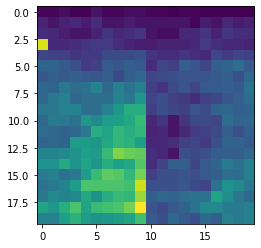

In [46]:
plt.imshow(expt_num_wt)

In [ ]:
plt.xlabel("time bins")
plt.ylabel("radial bins")
plt.title('No. of wild-type cells')
#plt.ylim(10, num_radial_bins-0.5)
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.imshow(num_wt)
plt.colorbar()
plt.savefig(os.path.join(root_path, 'Scr_17_num_wt_new.png'), bbox_inches = 'tight')

In [ ]:
plt.title('mitosis kymograph')
plt.xlabel("time bins")
plt.ylabel("radial bins")
plt.ylim(0, num_radial_bins-0.5)
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
plt.imshow(num_wt_mito)
plt.colorbar()

In [ ]:
plt.title('Probability of mitosis kymograph')
plt.xlabel("time bins")
plt.ylabel("radial bins")
plt.ylim(0, num_radial_bins-0.5)
plt.yticks(ylocs, ylabels)
plt.xticks(xlocs, xlabels, rotation='vertical')
prob_mito = num_wt_mito / num_wt
plt.imshow(prob_mito)
plt.colorbar()

output - writing dir locations to automatically output kymographs

### Launch napari to check against raw data 

In [ ]:
with napari.gui_qt():
    viewer = napari.Viewer()
    
    #viewer.add_image(bf)
    viewer.add_image(gfp, name="gfp", blending = "additive", colormap = "green")
    viewer.add_image(rfp, name="rfp", contrast_limits = (0, 50), blending = "additive", colormap = "red")
    
    viewer.add_tracks(wt_data)
    viewer.add_tracks(scr_data)
    
    plot_mitoses() ## utilises two functions above to plot apop and mito 
    plot_apoptosis()
    viewer.dims.set_point(0, (apop_time + delta_t)) ## open viewer at the timepoint of interest

# misc

In [ ]:
### checking how the tracker classifies state labels leading up to mitosis, seems the best classification is just a single metaphase but also double metaphase maybe more rigorous
count1 = 0
count2 = 0
for i, wt_track in enumerate(wt_tracks):
    if wt_track.fate.name == "DIVIDE":
        count1 += 1
        print(i,wt_track.ID, wt_track.label[-5:])
        if str(wt_track.label[-1:]) == "['METAPHASE']": #"['METAPHASE', 'METAPHASE']"
            count2 += 1
print("accuracy of classification above is", (count2/count1 *100))

distance binned but time not 

In [ ]:
t_range = range(-200,200)
wt_mito_ID_temporal_bins = {}

## create bins automatically
num_bins = 10
bin_size = radius / num_bins
## create dict for wt data storage
wt_track_bins = {}
wt_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data
wt_mitosis_bins = {}
wt_mito_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data

wt_tracks_in_radius = []
wt_mitosis_in_radius = []

for delta_t in t_range:
    ## creating temporal bin label
    temporal_bin_label = "frame" + str(find_apoptosis_time(target_track, index = False) + delta_t)
    wt_mito_ID_temporal_bins[temporal_bin_label] = {}
    radius = 500 ## maximum radius
    ## count all cells and mitoses within radius at delta_t
   
    wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)
    print("time", delta_t, "wt", len(wt_tracks_in_radius), "mito", len(wt_mitosis_in_radius))## currently returning zero hmmm
    ## iterate over all bins
    for i in range(num_bins):
        ## create bin label for dict entry 
        bin_label = str((bin_size * i)) + "< radial distance <" + str((bin_size * (i+1))) 
        ## create empty list to store each bins data in before storing
        wt_trackz = []
        wt_IDs = [] ## temp measure
        for wt_track in wt_tracks_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_track, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_trackz.append(wt_track) 
                wt_IDs.append(wt_track.ID) ## temp measure
        ## add list of cells to dict entry
        wt_track_bins[bin_label] = wt_tracks
        wt_ID_bins[bin_label] = wt_IDs

        wt_mito_IDs = [] ## temp measure
        wt_mitos = []
        for wt_mito in wt_mitosis_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_mito, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_mitos.append(wt_mito) 
                wt_mito_IDs.append(wt_mito.ID) ## temp measure
        ## add list of cells to dict entry
        wt_mitosis_bins[bin_label] = wt_mitos
        wt_mito_ID_bins[bin_label] = wt_mito_IDs
        #print(wt_mito_IDs, delta_t)
        
        #wt_mito_ID_temporal_bins[temporal_bin_label][bin_label] = wt_mito_IDs

In [ ]:
wt_mito_ID_temporal_bins

plotting wt_mito_ID_temporal_bins

In [ ]:
wt_mito_ID_temporal_bins['frame685']

In [ ]:
heatmap = np.zeros((10,400))

for i, key1 in enumerate(wt_mito_ID_temporal_bins.keys()):
    #print(i, key1)
    for j, key2 in enumerate(wt_mito_ID_temporal_bins['frame685'].keys()):
        #print(j,key2)
        if len(wt_mito_ID_temporal_bins[key1][key2]) > 4:
            print(key1, key2)
            print(len(wt_mito_ID_temporal_bins[key1][key2]))
        heatmap[j,i] = len(wt_mito_ID_temporal_bins[key1][key2])
#heatmap[:,0] = wt_mito_ID_temporal_bins[i][j]

In [ ]:
plt.imshow(heatmap, cmap= 'viridis', aspect = 'auto')#, #interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,9)
#plt.xlim(0,10)
#plt.clim(0,3)
plt.title("Number of wild-type mitosis")
plt.text(195,-4.5, "Scr apoptosis -", rotation=90)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (50pixel bins)")
plt.savefig("/home/nathan/data/number_heatmap_Scr17.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()